In [162]:
from constants import DECK
import pandas as pd
import numpy as np
from simulation import simulate_hand
from itertools import combinations
from utils import card_distance, Card, Hand
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# num_sims = 1_000
# num_villans = 1
# res = []
# for hero_hole_cards in combinations(DECK, 2):
#     win_rates = simulate_hand(hero_hole_cards, num_villans=num_villans, num_sims=num_sims)
#     flop_win_rate, turn_win_rate, river_win_rate = win_rates
#     res.append({
#         'hole_card1': sorted(hero_hole_cards)[0],
#         'hole_card2': sorted(hero_hole_cards)[1],
#         'flop_win_rate': flop_win_rate,
#         'turn_win_rate': turn_win_rate,
#         'river_win_rate': river_win_rate
#     })
# data = pd.DataFrame(res)
# data.to_csv("data/simulation_data.csv,index=False")

In [20]:
data = pd.read_csv('data/simulation_data.csv')
data.drop('Unnamed: 0',axis=1, inplace=True)

In [22]:
data['connectedness'] = data.apply(
    lambda x: card_distance([Card(x.hole_card1), Card(x.hole_card2)]), 
    axis=1)

data['pair'] = (data['connectedness'] == 0).astype(int)
data['suited'] = data.apply(
    lambda x: int(Card(x.hole_card1).suit_idx == Card(x.hole_card2).suit_idx),
    axis=1)

In [23]:
data.head()

,hole_card1,hole_card2,flop_win_rate,turn_win_rate,river_win_rate,connectedness,pair,suited
0,2c,2d,0.677,0.594,0.499,0,1,0
1,2c,2h,0.671,0.587,0.487,0,1,0
2,2c,2s,0.671,0.585,0.499,0,1,0
3,2c,3c,0.235,0.290,0.326,1,0,1
4,2c,3d,0.233,0.276,0.303,1,0,0


In [143]:
class PokerDataset(Dataset):
    def __init__(self, data):
        hole_card_list = sorted([tuple(sorted(Hand([c1,c2]).vector.tolist())) for c1, c2 in combinations(DECK,2)])
        self.hole_card_idx_dict = {hole_cards: i for i, hole_cards in enumerate(hole_card_list)}
        self.data = data
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        attributes = [row['suited'], row['connectedness'], row['pair']]
        hole_cards = Hand([row['hole_card1'], row['hole_card2']]).vector.tolist()
        hand = tuple(sorted(hole_cards))
        hand_idx = self.hole_card_idx_dict[hand]
        win_percentage = row['river_win_rate']
        return (
            torch.tensor(hand_idx),
            torch.tensor(hand),
            torch.tensor(attributes, dtype=torch.float32), 
            torch.tensor(win_percentage, dtype=torch.float32)
            )

In [144]:
dataset = PokerDataset(data)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [59]:
import torch.nn as nn

In [145]:
ex_batch = next(iter(dataloader))

In [146]:
class CardEmbeddingModel(nn.Module):
    def __init__(self, embedding_dim=2):
        super().__init__()
        self.embedder = nn.Embedding(1326, embedding_dim)
    def forward(self, x):
        x_embed = self.embedder(x)
        return x_embed

In [147]:
ex_batch[3]

tensor([0.4860, 0.5410, 0.3730, 0.5080, 0.4530, 0.2790, 0.5760, 0.4390, 0.3900,
        0.4790, 0.4740, 0.5550, 0.5960, 0.3090, 0.5840, 0.5630, 0.5000, 0.5690,
        0.6090, 0.6710, 0.5070, 0.4350, 0.3860, 0.4730, 0.5890, 0.5210, 0.4810,
        0.3760, 0.6160, 0.7120, 0.4080, 0.6010])

In [148]:
class HandWinPredictor(nn.Module):
    def __init__(self, card_embedding_dim=2, hidden_dims=[128, 64, 32]):
        super(HandWinPredictor, self).__init__()
        
        self.encoder = CardEmbeddingModel(card_embedding_dim)
        
        layers = []
        prev_dim = card_embedding_dim + 3
        for dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, dim))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(dim))
            prev_dim = dim
        
        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dims[-1], 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, hole_card_idx, hole_card_attributes):
        hole_card_embedding = self.encoder(hole_card_idx)
        x = torch.concat([hole_card_embedding, hole_card_attributes], dim=1)
        x = self.hidden_layers(x)
        x = self.output_layer(x)
        return self.sigmoid(x)
        

In [163]:
model = HandWinPredictor(card_embedding_dim=2, hidden_dims=[128,64,32])
optimizer = torch.optim.SGD(params=model.parameters(), lr=.001)
loss_fn = nn.MSELoss()
epochs=100

In [164]:
train_losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in dataloader:
        hole_card_idx, hole_card, hole_card_attributes, targets = batch
        optimizer.zero_grad()
        outputs = model(hole_card_idx, hole_card_attributes)
        loss = loss_fn(outputs, targets.unsqueeze(1))
        loss.backward()
        optimizer.step()
            
        total_loss += loss.item()
    avg_loss = total_loss/len(dataloader)
    train_losses.append(avg_loss)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {round(avg_loss, 5)}")
    

Epoch 5/100, Loss: 0.02684
Epoch 10/100, Loss: 0.02046
Epoch 15/100, Loss: 0.01688
Epoch 20/100, Loss: 0.01497
Epoch 25/100, Loss: 0.01361
Epoch 30/100, Loss: 0.01287
Epoch 35/100, Loss: 0.01178
Epoch 40/100, Loss: 0.012
Epoch 45/100, Loss: 0.01122
Epoch 50/100, Loss: 0.01133
Epoch 55/100, Loss: 0.01106
Epoch 60/100, Loss: 0.0115
Epoch 65/100, Loss: 0.01053
Epoch 70/100, Loss: 0.01075
Epoch 75/100, Loss: 0.01075
Epoch 80/100, Loss: 0.0105
Epoch 85/100, Loss: 0.01047
Epoch 90/100, Loss: 0.01025
Epoch 95/100, Loss: 0.01049
Epoch 100/100, Loss: 0.01034


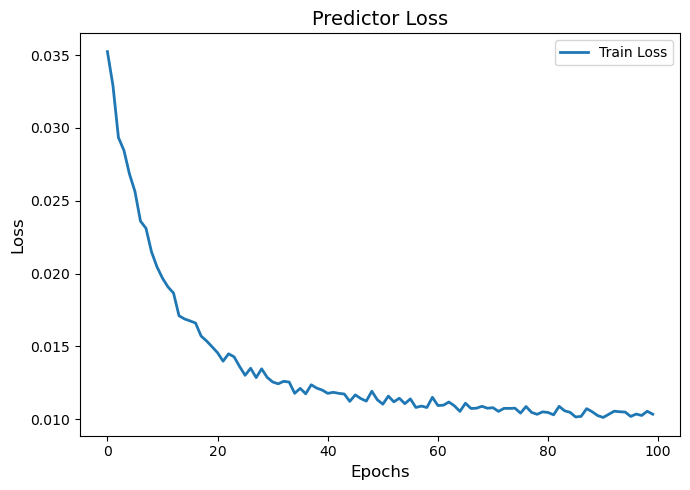

In [165]:
plt.figure(figsize=(7, 5))
sns.lineplot(x=list(range(epochs)), y=train_losses, label="Train Loss", linestyle='-', linewidth=2)
plt.title("Predictor Loss", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend(fontsize=10) 
plt.tight_layout()
plt.show()